In [68]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression

In [69]:
df=pd.read_csv("WorldEnergyConsumption.csv")

In [70]:
df= df.drop(df.columns[df.isnull().sum()>11000],axis=1)    


In [71]:
df=df.drop(["iso_code"],axis=1)

In [72]:
df["year"]=df["year"].astype(float)


In [73]:
imputer = IterativeImputer(estimator=BayesianRidge(), random_state=18)
numeric_cols = df.select_dtypes(include=[np.number])
df[numeric_cols.columns] = imputer.fit_transform(numeric_cols)

In [74]:
df = df.sort_values(by=["country", "year"])
df.head()

,country,year,population,gdp,coal_prod_change_twh,coal_prod_per_capita,coal_production,energy_cons_change_pct,energy_cons_change_twh,gas_prod_change_twh,gas_prod_per_capita,gas_production,oil_prod_change_twh,oil_prod_per_capita,oil_production,primary_energy_consumption
0,ASEAN (Ember),2000.0,1.057053e+08,9.911174e+11,24.338319,4247.032796,1298.264497,3.928096,86.920599,24.024761,10564.739249,961.109124,22.377406,39381.846393,1471.306620,4578.352523
1,ASEAN (Ember),2001.0,1.057053e+08,9.911176e+11,24.548208,4244.821345,1304.778168,3.917958,86.661951,24.194715,10690.916698,970.963430,22.330263,39341.570137,1481.359591,4595.761613
2,ASEAN (Ember),2002.0,1.057053e+08,9.911178e+11,24.758098,4242.609894,1311.291839,3.907821,86.403303,24.364670,10817.094147,980.817736,22.283119,39301.293882,1491.412561,4613.170703
3,ASEAN (Ember),2003.0,1.057053e+08,9.911181e+11,24.967988,4240.398444,1317.805510,3.897684,86.144654,24.534624,10943.271596,990.672042,22.235975,39261.017626,1501.465531,4630.579792
4,ASEAN (Ember),2004.0,1.057053e+08,9.911183e+11,25.177878,4238.186993,1324.319181,3.887546,85.886006,24.704578,11069.449045,1000.526348,22.188831,39220.741371,1511.518501,4647.988882


In [75]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt



In [76]:
forecasts = {}
countries = df["country"].unique()
exog_vars = ["population","gdp","coal_prod_change_twh","coal_prod_per_capita","coal_production","energy_cons_change_pct","energy_cons_change_twh","gas_prod_change_twh","gas_prod_per_capita","gas_production","oil_prod_change_twh","oil_prod_per_capita","oil_production"]
for country in countries:

    country_df = df[df["country"]==country]
    X = country_df[exog_vars]
    y = country_df["primary_energy_consumption"]
    try:
        model = SARIMAX(y, exog=X, order=(3,1,1), seasonal_order=(1,1,1,12))  
        model_fit = model.fit()
        future_years = pd.DataFrame({"year": range(2021, 2041)})
        
        future_X = pd.DataFrame({i: [X[i].iloc[-1]] * 20 for i in exog_vars})

        forecast = model_fit.forecast(steps=20, exog=future_X)

        forecasts[country] = pd.DataFrame({"year": future_years["year"], "predicted_energy": forecast})
    
    except Exception as e:
        print(f"Error for {country}: {e}")

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\st

Error for Serbia and Montenegro: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index w

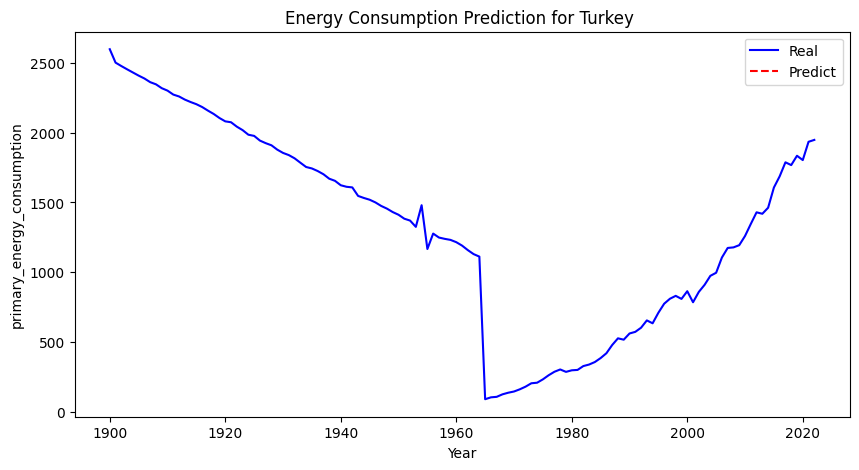

In [77]:
country = "Turkey"
forecast = forecasts[country]

plt.figure(figsize=(10,5))
plt.plot(df[df["country"] == country]["year"], df[df["country"] == country]["primary_energy_consumption"], label="Real", color="blue")
plt.plot(forecast["year"], forecast["predicted_energy"], label="Predict", linestyle="dashed", color="red")
plt.xlabel("Year")
plt.ylabel("primary_energy_consumption")
plt.title(f"Energy Consumption Prediction for {country} ")
plt.legend()
plt.show()